In [1]:
from typing import List

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

from ped_anova import compute_hpi

os.makedirs("figs/", exist_ok=True)

plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["font.size"] = 48
plt.rcParams['mathtext.fontset'] = 'stix'  # The setting of math font

## Load experiment results

In [2]:
config_table = pd.read_csv("results/setting-table.csv", index_col=0)
assert len(config_table) == 1600 + 1

mean_vals = pd.read_csv("results/mean_vals.csv")
OPTUNA_INDEX = config_table[config_table.alpha.isna()].index.tolist()
optuna_vals = mean_vals[np.any([mean_vals.setting_index == idx for idx in OPTUNA_INDEX], axis=0)]
mean_vals = mean_vals[np.all([mean_vals.setting_index != idx for idx in OPTUNA_INDEX], axis=0)]

target_names = mean_vals.target.unique()
target_cols = mean_vals.target
target_names

array(['cifar10', 'slice_localization', 'parkinsons_telemonitoring',
       'colorectal_histology', 'fashion_mnist', 'naval_propulsion',
       'protein_structure', 'XinSheYang_10d', 'Rosenbrock_30d',
       'credit_g', 'KTablet_10d', 'Levy_10d', 'WeightedSphere_30d',
       'XinSheYang_05d', 'Styblinski_30d', 'Levy_05d',
       'blood_transfusion', 'Levy_30d', 'XinSheYang_30d',
       'WeightedSphere_10d', 'Perm_05d', 'Rastrigin_30d', 'Schwefel_30d',
       'Sphere_05d', 'Ackley_05d', 'Griewank_10d', 'Rosenbrock_05d',
       'Sphere_30d', 'Styblinski_05d', 'phoneme', 'Styblinski_10d',
       'Ackley_30d', 'Griewank_30d', 'Schwefel_10d', 'Schwefel_05d',
       'Sphere_10d', 'Perm_30d', 'Griewank_05d', 'Rosenbrock_10d',
       'Perm_10d', 'segment', 'WeightedSphere_05d', 'KTablet_30d',
       'KTablet_05d', 'car', 'australian', 'Rastrigin_10d',
       'Rastrigin_05d', 'Ackley_10d', 'kc1', 'vehicle'], dtype=object)

## Preprocess results

In [3]:
config_table = config_table[config_table["weight"] != "weaker-smaller"]

optuna_mask = config_table.alpha.isna()
linear_mask = config_table["quantile"] == "linear"
sqrt_mask = config_table["quantile"] == "sqrt"
categorical_mask = ~config_table["top"].isna()

config_cat = config_table[~optuna_mask & categorical_mask]
config_num = config_table[~optuna_mask & ~categorical_mask]

config_num = config_num.drop(columns=["top"])

### Figures to create

Def: No. params is $D$, No. settings is $K$.

1. HPI for Bench5D, Bench10D, Bench30D, HPOBench, HPOlib, and JAHS-Bench (table)
2. Marginal distributions for each param for each setting ($5 \times D \times K$ subfigures)
3. The HPI ranking distribution at 50,100,150,200 for each ($5 \times D \times K$ subfigures)

In [4]:
from parzen_estimator import (
    CategoricalParzenEstimator,
    CategoricalUniform,
    NumericalParzenEstimator,
    NumericalUniform,
)

is_categoricals = {
    "multivariate": True,
    "quantile": True,
    "alpha": False,
    "weight": True,
    "prior": True,
    "magic-clip": True,
    "top": True,
}


def get_pdf(
    X_top: np.ndarray,
    n_choices: int,
    is_categorical: bool,
):
    if is_categorical:
        pdf = CategoricalParzenEstimator(
            samples=X_top, top=1.0, n_choices=n_choices, prior=False,
        )
    else:
        pdf = NumericalParzenEstimator(
            samples=X_top,
            lb=0,
            ub=n_choices - 1,
            q=1,
            compress=True,
            dtype=int,
            prior=False,
        ) if X_top.size > 0 else NumericalUniform(lb=0, ub=n_choices - 1)
    return pdf


def build_pdf(
    param_name: str,
    X: pd.DataFrame,
    F: np.ndarray,
    order: np.ndarray,
    top_quantile: float,
):
    top_mask = F <= F[order[int(top_quantile * F.size)]]
    if param_name == "alpha":
        linear_mask = X["quantile"] == "linear"
        x = X[param_name]

        codes, unique_vals = x[linear_mask].factorize(sort=True)
        n_choices = unique_vals.size
        pdf_linear = get_pdf(codes[top_mask[linear_mask]], n_choices, is_categorical=False)

        codes, unique_vals = x[~linear_mask].factorize(sort=True)
        n_choices = unique_vals.size
        pdf_sqrt = get_pdf(codes[top_mask[~linear_mask]], n_choices, is_categorical=False)
        return pdf_linear, pdf_sqrt


    codes, unique_vals = X[param_name].factorize(sort=True)
    n_choices = unique_vals.size
    is_categorical = is_categoricals[param_name]
    return get_pdf(codes[top_mask], n_choices, is_categorical)


def collect_pdfs(
    target_name: str,
    target_config: pd.DataFrame,
    top_quantile: float,
):
    pdf_dict = dict()
    target_epochs = np.asarray([50, 100, 150, 200]) - 1
    target_mean = mean_vals[target_cols == target_name]

    F_dict = {e: [] for e in target_epochs}
    for idx in target_config.index:
        m = target_mean[target_mean.setting_index == idx].iloc[0].to_numpy()[2:].astype(np.float32)
        for e in target_epochs:
            F_dict[e].append(m[e])
    else:
        F_dict = {e: np.asarray(F) for e, F in F_dict.items()}

    for e in target_epochs:
        F = F_dict[e]
        order = np.argsort(F)
        for param_name in target_config.columns:
            # key: "param_name:n_evals:top-quantile"
            if param_name == "alpha":
                pdf_linear, pdf_sqrt = build_pdf(param_name, target_config, F, order, top_quantile)
                key_linear = f"linear_{param_name}:{e+1:0>3}:{int(top_quantile * 100):0>2}"
                key_sqrt = f"sqrt_{param_name}:{e+1:0>3}:{int(top_quantile * 100):0>2}"
                pdf_dict[key_linear], pdf_dict[key_sqrt] = pdf_linear, pdf_sqrt
            else:
                pdf = build_pdf(param_name, target_config, F, order, top_quantile)
                key = f"{param_name}:{e+1:0>3}:{int(top_quantile * 100):0>2}"
                pdf_dict[key] = pdf

    return pdf_dict

## Build all required density estimators

In [5]:
cat_benches = [
    "parkinsons_telemonitoring", "protein_structure", "naval_propulsion", "slice_localization",
    "cifar10", "fashion_mnist", "colorectal_histology"
]
PC1, PC2 = 50, 5

pdf_dict = dict()
for target_name in target_names:
    pdf_dict[target_name] = {}
    if target_name in cat_benches:
        pdf_dict[target_name].update(collect_pdfs(target_name, config_cat, top_quantile=PC1/100))
        pdf_dict[target_name].update(collect_pdfs(target_name, config_cat, top_quantile=PC2/100))
    else:
        pdf_dict[target_name].update(collect_pdfs(target_name, config_num, top_quantile=PC1/100))
        pdf_dict[target_name].update(collect_pdfs(target_name, config_num, top_quantile=PC2/100))

In [9]:
unique_val_dict = {}
for col in config_cat.columns:
    if col != "alpha":
        unique_val_dict[col] = list(config_cat[col].factorize(sort=True)[1])
    else:
        linear_mask = config_cat["quantile"] == "linear"
        unique_val_dict[f"linear_{col}"] = list(config_cat[linear_mask][col].factorize(sort=True)[1])
        unique_val_dict[f"sqrt_{col}"] = list(config_cat[~linear_mask][col].factorize(sort=True)[1])

unique_val_dict = {k: [str(v) for v in uvs] for k, uvs in unique_val_dict.items()}
unique_val_dict["weight"] = [
    {"expected-improvement": "EI", "uniform": "Uniform", "older-smaller": "Old decay", "older-drop": "Old drop"}[s]
    for s in unique_val_dict["weight"]
]
unique_val_dict["quantile"] = [{"linear": "Linear", "sqrt": "Sqrt"}[s] for s in unique_val_dict["quantile"]]

param_name_dict = {
    "multivariate": "Multivariate",
    "prior": "Prior",
    "magic-clip": "Magic clipping",
    "quantile": "Splitting algorithm",
    "linear_alpha": "$\\beta_1$ (Linear)",
    "sqrt_alpha": "$\\beta_2$ (Sqrt)",
    "weight": "Weighting algorithm",
}


def plot_pdf(bench_names, bbox_to_anchor):
    global_hpi_df, local_hpi_df = [], []
    for r, n_evals in enumerate([50, 100, 150, 200]):
        param_names = list(set([k.split(":")[0] for k in pdf_dict[bench_names[0]].keys()]))
        global_hpi, local_hpi = {}, {}
        lines = []

        for c, (param_name, title) in enumerate(param_name_dict.items()):
            ax = axes[r][c]
            unique_vals = unique_val_dict[param_name]
            dx = np.arange(len(unique_vals))

            global_hpi[param_name], local_hpi[param_name] = 0.0, 0.0
            avg_pdf_global, avg_pdf_local = np.zeros(len(unique_vals)), np.zeros(len(unique_vals))
            for target_name in bench_names:
                pdf_global = pdf_dict[target_name][f"{param_name}:{n_evals:0>3}:{PC1:0>2}"]
                pdf_local = pdf_dict[target_name][f"{param_name}:{n_evals:0>3}:{PC2:0>2}"]
                dx = np.arange(len(unique_vals))
                pg, pl = pdf_global(dx), pdf_local(dx)
                avg_pdf_global += pg
                avg_pdf_local += pl
                local_hpi[param_name] += pg @ ((pl / np.maximum(1e-12, pg) - 1) ** 2)
                global_hpi[param_name] += np.mean((dx.size * pg - 1) ** 2)
            else:
                local_hpi[param_name] /= len(bench_names)
                global_hpi[param_name] /= len(bench_names)
                avg_pdf_local /= len(bench_names)
                avg_pdf_global /= len(bench_names)

            buf = 0.5
            line1 = ax.bar(unique_vals, avg_pdf_global, alpha=0.2, color="blue")
            line2 = ax.bar(unique_vals, avg_pdf_local, alpha=0.2, color="red")
            line3 = ax.hlines(1 / dx.size, -buf, dx.size - 1 + buf, color="black", linestyle="--")
            ax.set_xlim(-buf, dx.size - 1 + buf)
            ax.set_ylim(0, 1)
            ax.grid()
            if r == 0:
                ax.set_title(title, fontsize=48)
            if c == 0:
                ax.set_ylabel(f"{n_evals} evaluations")
            if r != 3:
                ax.tick_params(labelbottom=False, bottom=False)
            elif param_name == "weight":
                ax.tick_params(axis="x", labelrotation=30)

            if len(lines) == 0:
                lines = [line1, line2, line3]
        else:
            sg, sl = sum(global_hpi.values()), sum(local_hpi.values())
            label_dict = param_name_dict.copy()
            label_dict.update({
                "linear_alpha": "$\\beta_1$ (Linear)",
                "sqrt_alpha": "$\\beta_2$ (Sqrt)",
            })
            global_hpi_df.append({label_dict[k]: f"{v * 100 / sg:.2f}\\%" for k, v in global_hpi.items()})
            local_hpi_df.append({label_dict[k]: f"{v * 100 / sl:.2f}\\%" for k, v in local_hpi.items()})

    labels = [f"Top-{PC1}% probability mass", f"Top-{PC2}% probability mass", "Uniform"]
    axes[-1][len(axes[0]) // 2].legend(
        handles=lines,
        loc='upper center',
        labels=labels,
        fontsize=48,
        bbox_to_anchor=bbox_to_anchor,  # ここは調整が必要です
        fancybox=False,
        ncol=len(labels)
    )
    fig.supylabel("Probability mass", x=0.085, fontsize=48)
    print(pd.DataFrame(global_hpi_df).T.style.to_latex())
    print(pd.DataFrame(local_hpi_df).T.style.to_latex())

\begin{tabular}{lllll}
 & 0 & 1 & 2 & 3 \\
Multivariate & 23.67\% & 41.39\% & 48.67\% & 50.81\% \\
Prior & 6.21\% & 4.65\% & 6.57\% & 8.45\% \\
Magic clipping & 36.11\% & 21.65\% & 15.19\% & 10.45\% \\
Splitting algorithm & 1.09\% & 1.78\% & 1.95\% & 3.05\% \\
$\beta_1$ (Linear) & 9.80\% & 7.10\% & 5.80\% & 7.24\% \\
$\beta_2$ (Sqrt) & 19.24\% & 20.80\% & 17.64\% & 16.08\% \\
Weighting algorithm & 3.87\% & 2.62\% & 4.18\% & 3.92\% \\
\end{tabular}

\begin{tabular}{lllll}
 & 0 & 1 & 2 & 3 \\
Multivariate & 12.77\% & 14.71\% & 10.90\% & 11.28\% \\
Prior & 9.45\% & 10.47\% & 8.87\% & 10.19\% \\
Magic clipping & 10.35\% & 9.33\% & 8.77\% & 12.60\% \\
Splitting algorithm & 0.97\% & 3.33\% & 2.95\% & 3.09\% \\
$\beta_1$ (Linear) & 17.95\% & 11.04\% & 8.37\% & 16.86\% \\
$\beta_2$ (Sqrt) & 39.12\% & 27.89\% & 39.32\% & 22.36\% \\
Weighting algorithm & 9.39\% & 23.22\% & 20.82\% & 23.62\% \\
\end{tabular}

\begin{tabular}{lllll}
 & 0 & 1 & 2 & 3 \\
Multivariate & 8.39\% & 26.23\% & 44.48\% & 4

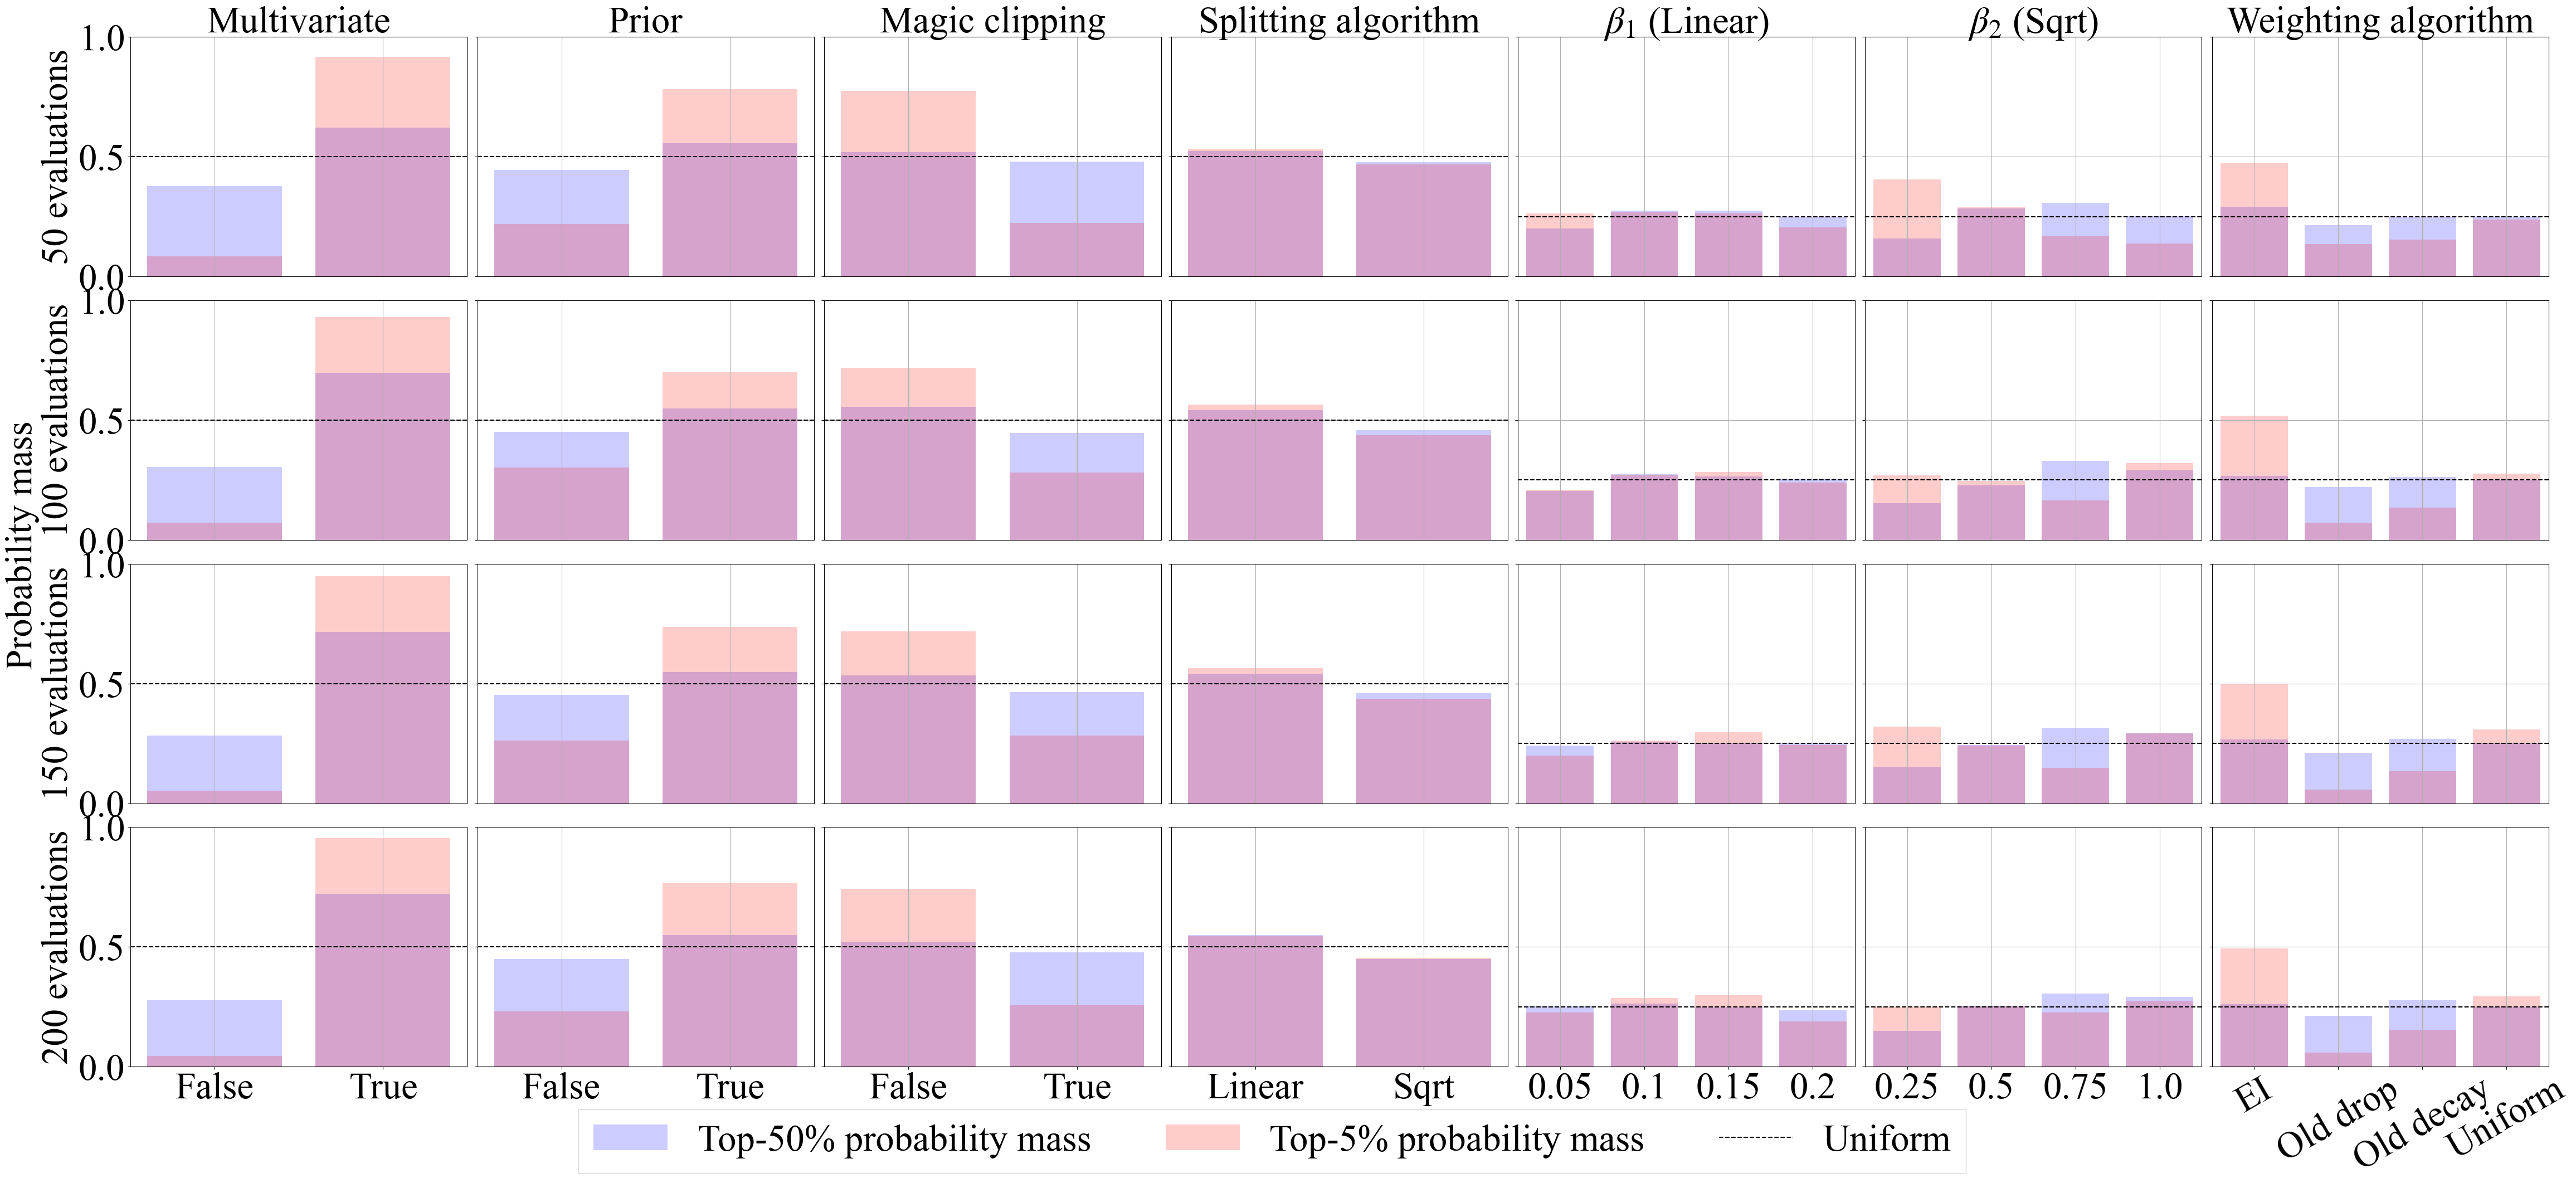

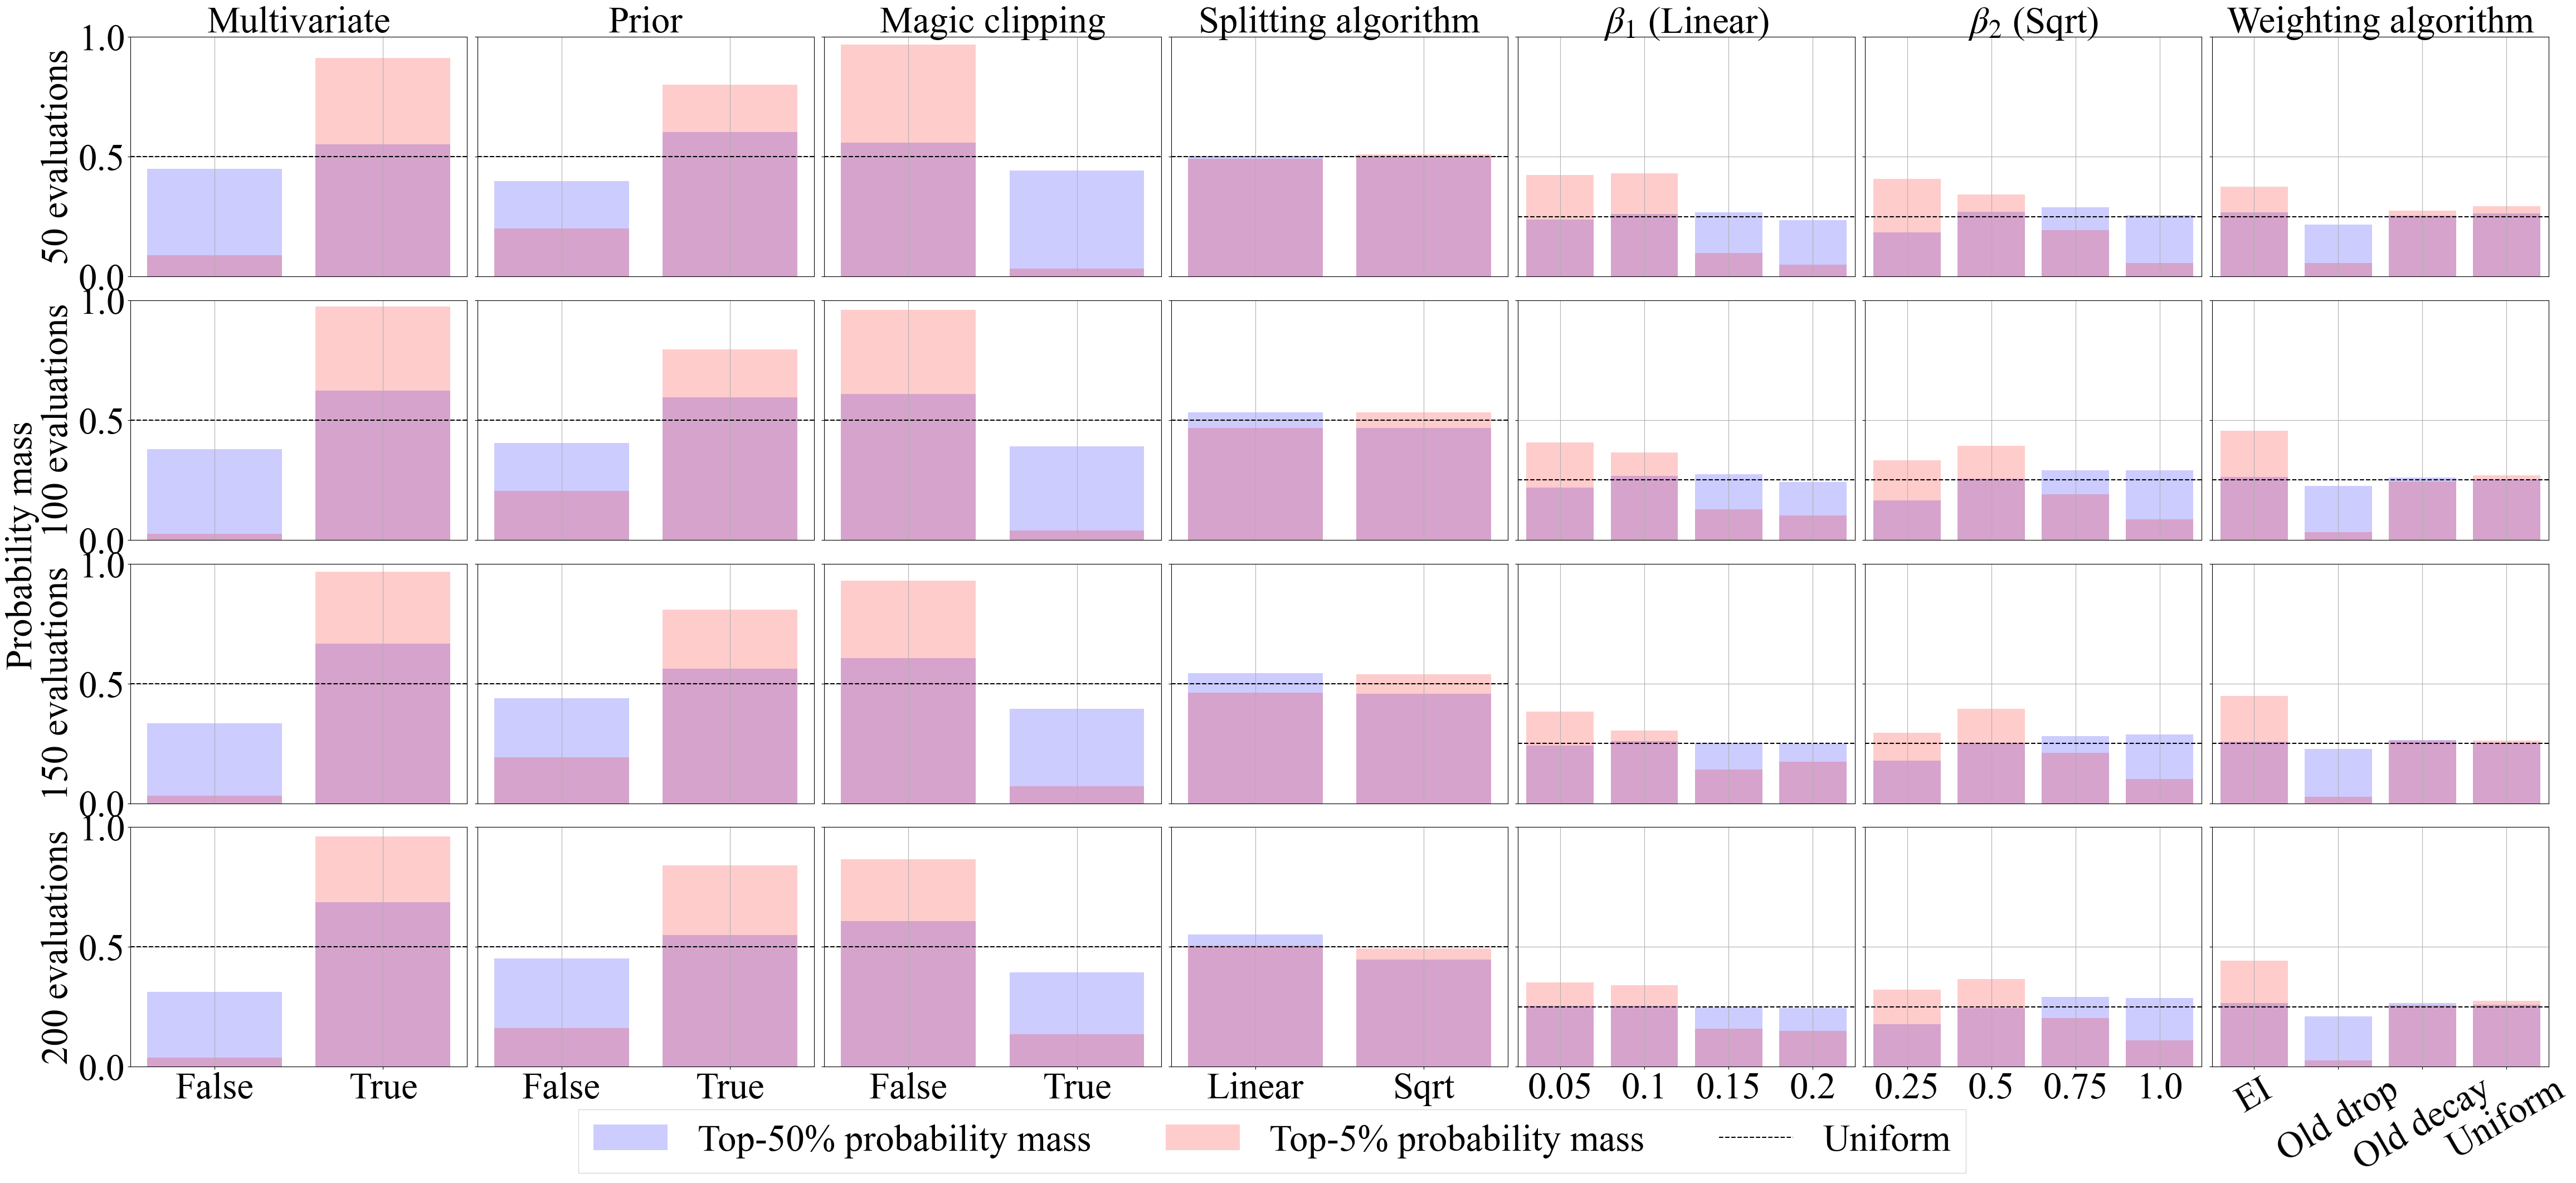

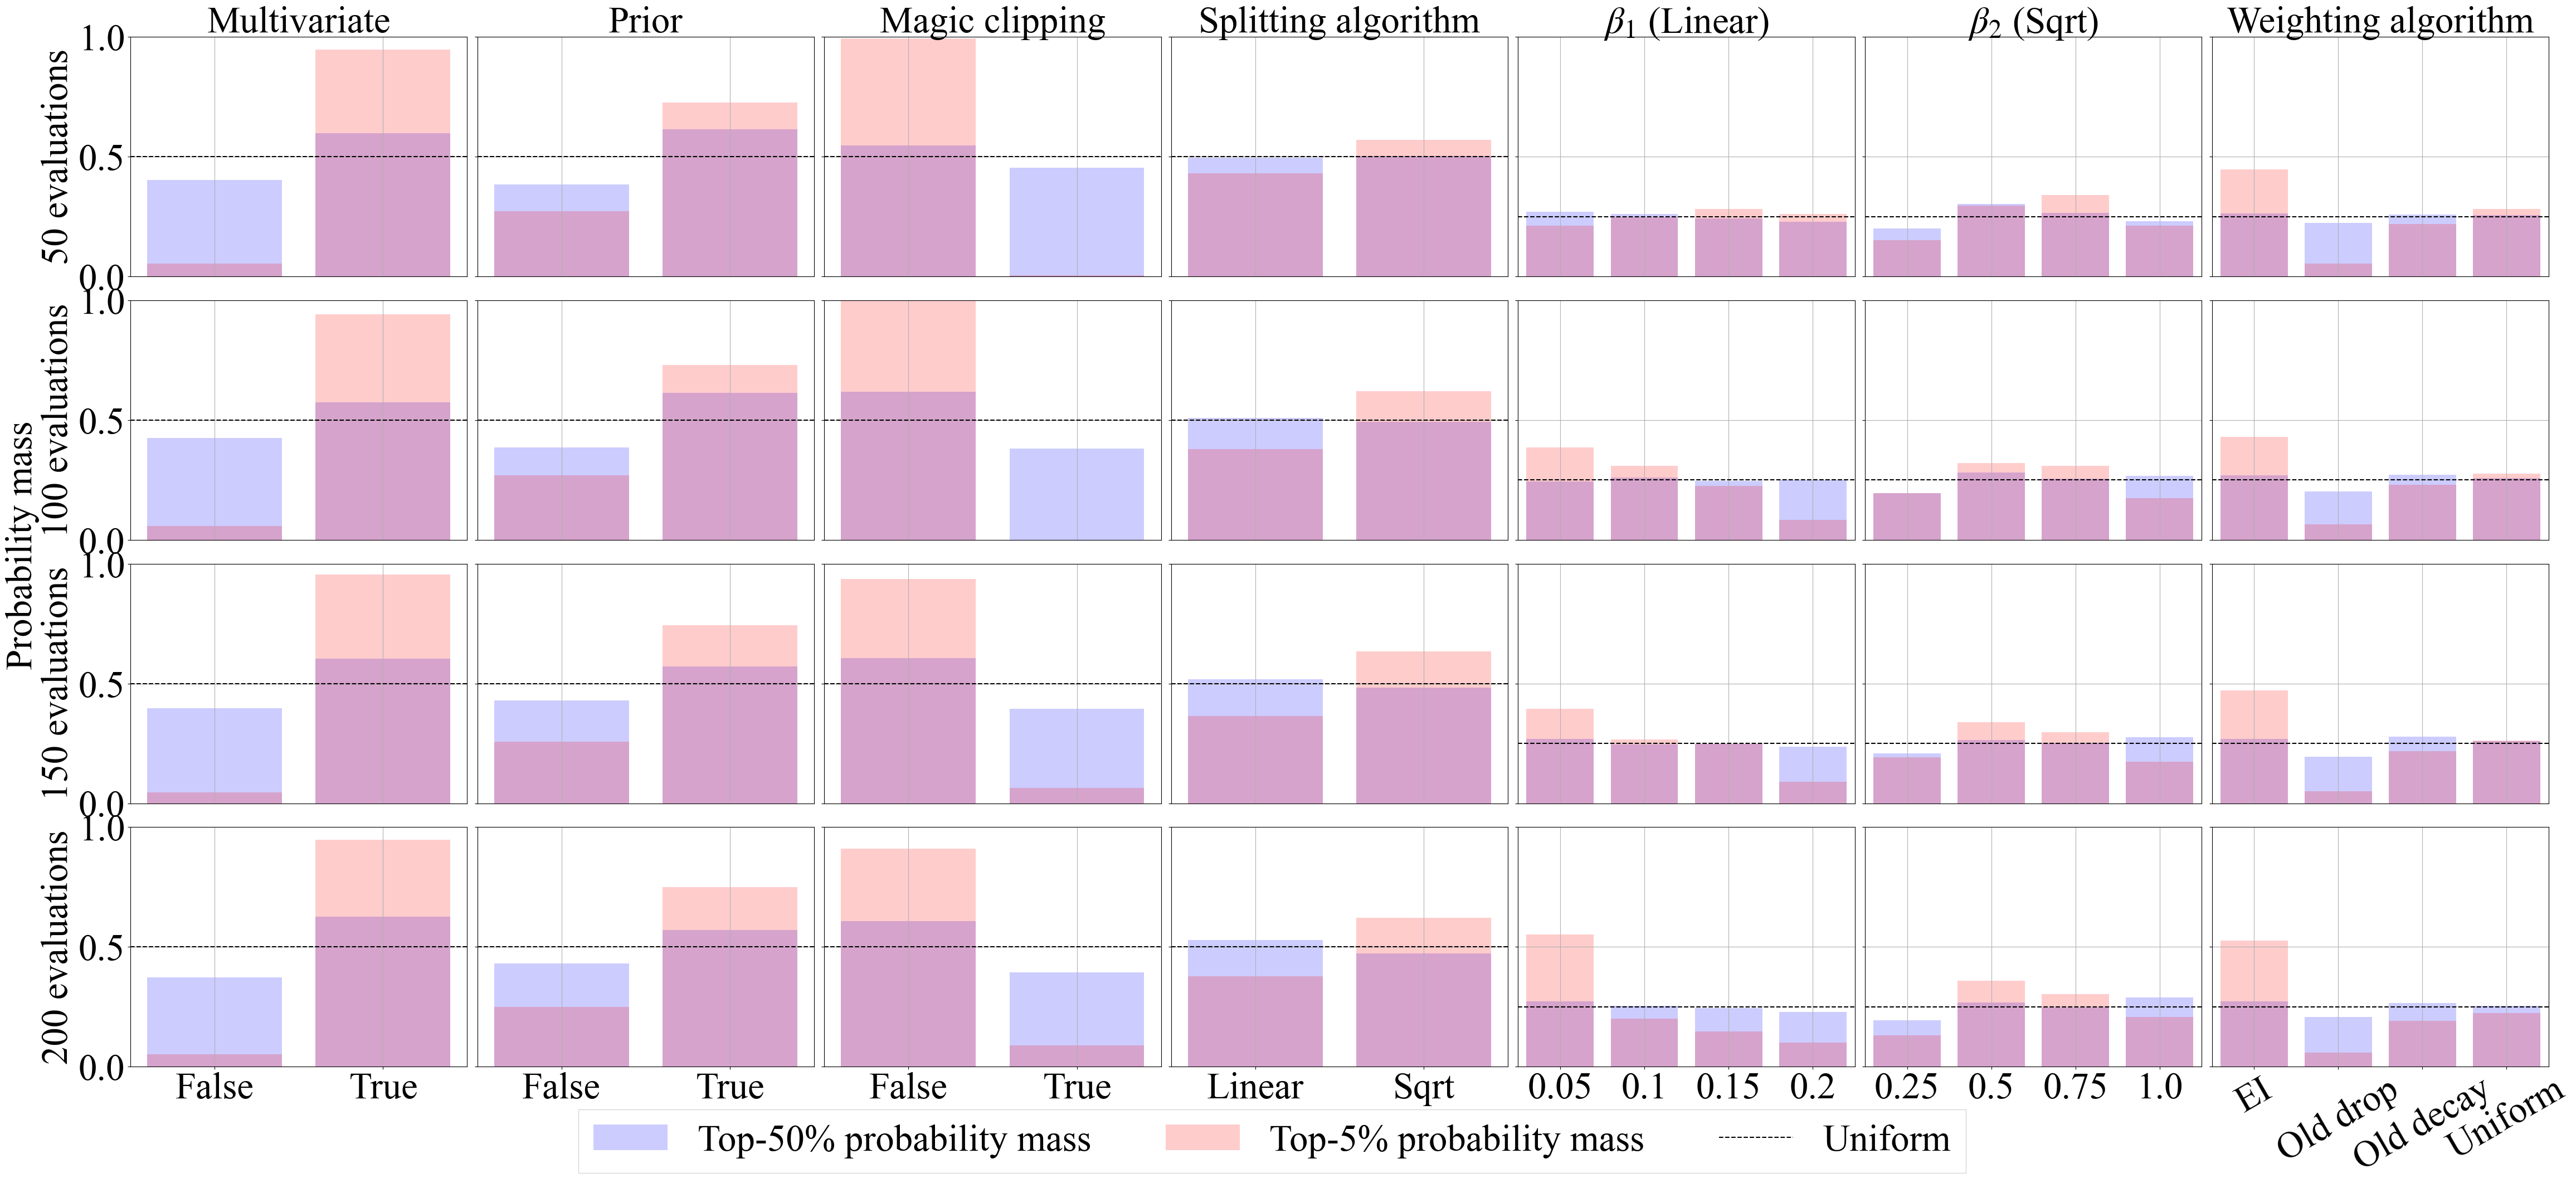

In [10]:
for suffix in ["_05d", "_10d", "_30d"]:
    fig, axes = plt.subplots(
        nrows=4,
        ncols=7,
        figsize=(56, 24),
        sharey=True,
        gridspec_kw=dict(
            wspace=0.03,
            hspace=0.1,
        )
    )

    bench_names = [name for name in target_names if name.endswith(suffix)]
    plot_pdf(bench_names, bbox_to_anchor=(0.3, -0.1))
    plt.savefig(f"figs/bench{suffix}-anova.pdf", bbox_inches="tight")

\begin{tabular}{lllll}
 & 0 & 1 & 2 & 3 \\
Multivariate & 1.41\% & 2.99\% & 3.29\% & 5.11\% \\
Prior & 15.43\% & 11.11\% & 11.78\% & 10.93\% \\
Magic clipping & 38.76\% & 63.38\% & 60.96\% & 62.16\% \\
Splitting algorithm & 2.00\% & 1.29\% & 1.11\% & 1.02\% \\
$\beta_1$ (Linear) & 12.61\% & 3.12\% & 6.00\% & 7.94\% \\
$\beta_2$ (Sqrt) & 27.87\% & 17.18\% & 15.49\% & 10.87\% \\
Weighting algorithm & 1.93\% & 0.93\% & 1.38\% & 1.97\% \\
\end{tabular}

\begin{tabular}{lllll}
 & 0 & 1 & 2 & 3 \\
Multivariate & 6.79\% & 8.35\% & 4.78\% & 6.36\% \\
Prior & 0.60\% & 1.95\% & 2.90\% & 3.30\% \\
Magic clipping & 10.16\% & 11.95\% & 12.77\% & 12.43\% \\
Splitting algorithm & 7.61\% & 12.26\% & 4.44\% & 2.98\% \\
$\beta_1$ (Linear) & 37.74\% & 29.52\% & 36.62\% & 42.21\% \\
$\beta_2$ (Sqrt) & 29.51\% & 28.03\% & 23.06\% & 15.18\% \\
Weighting algorithm & 7.59\% & 7.94\% & 15.43\% & 17.53\% \\
\end{tabular}



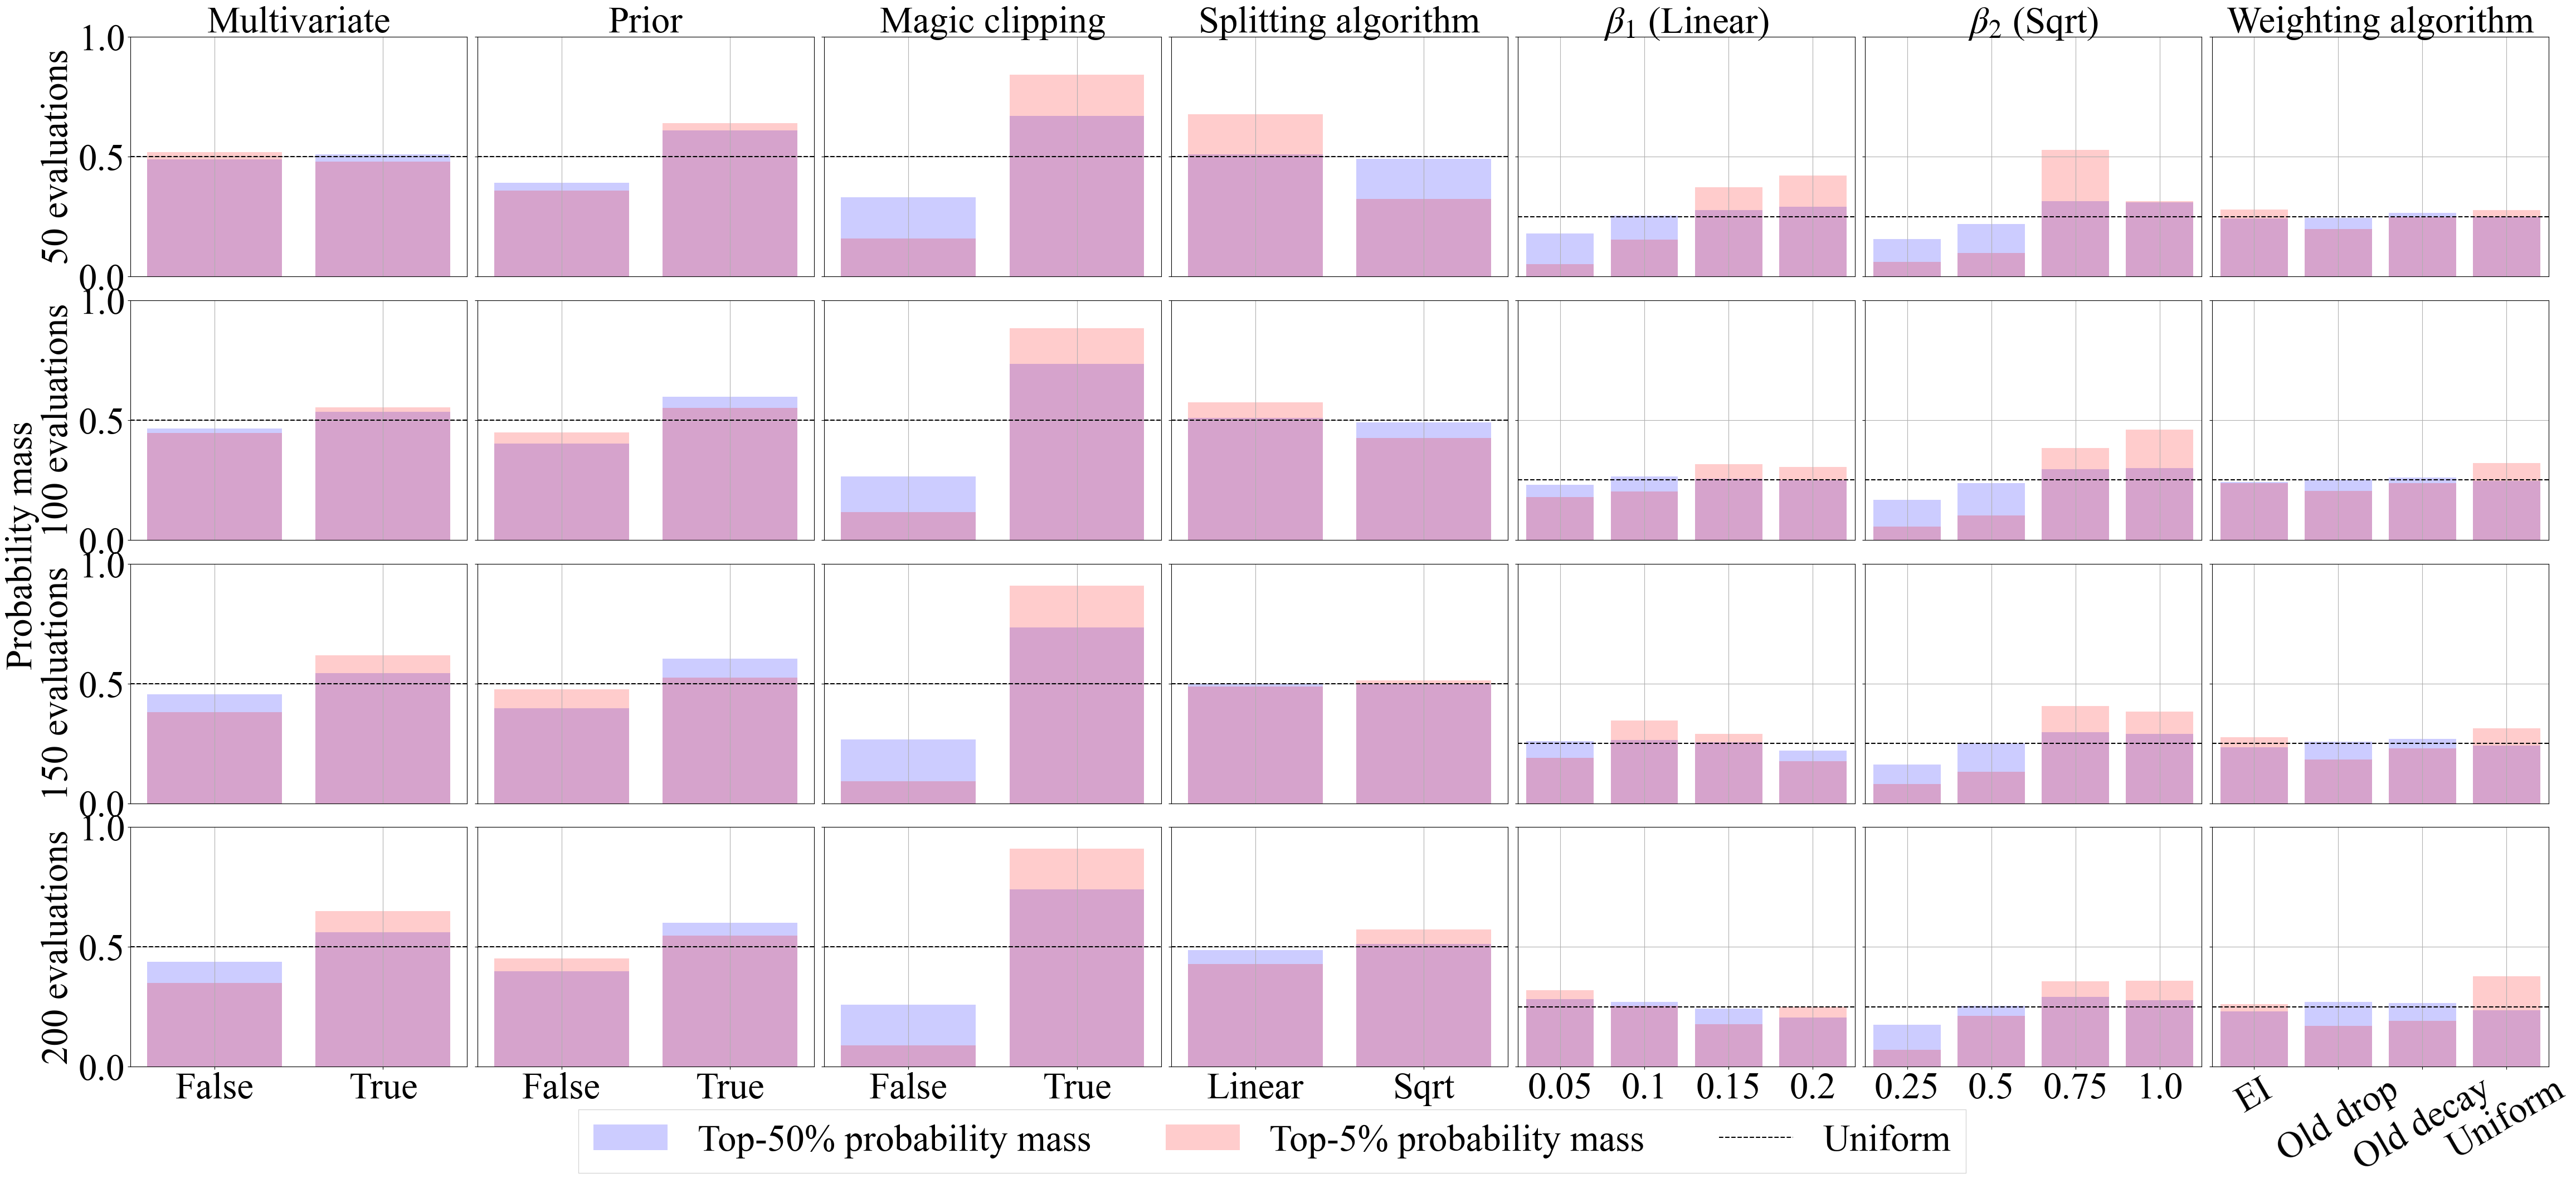

In [11]:
bench_names = [
    "vehicle",
    "segment",
    "car",
    "australian",
    "credit_g",
    "blood_transfusion",
    "kc1",
    "phoneme",
]

fig, axes = plt.subplots(
    nrows=4,
    ncols=7,
    figsize=(56, 24),
    sharey=True,
    gridspec_kw=dict(
        wspace=0.03,
        hspace=0.1,
    )
)

plot_pdf(bench_names, bbox_to_anchor=(0.3, -0.1))
plt.savefig(f"figs/hpobench-anova.pdf", bbox_inches="tight")

\begin{tabular}{lllll}
 & 0 & 1 & 2 & 3 \\
Multivariate & 3.06\% & 15.51\% & 19.25\% & 21.00\% \\
Prior & 8.88\% & 23.51\% & 31.62\% & 35.41\% \\
Magic clipping & 72.53\% & 38.75\% & 28.31\% & 22.96\% \\
Splitting algorithm & 0.30\% & 0.53\% & 1.51\% & 2.52\% \\
$\beta_1$ (Linear) & 6.32\% & 7.62\% & 6.33\% & 6.58\% \\
$\beta_2$ (Sqrt) & 6.70\% & 4.92\% & 2.34\% & 0.97\% \\
Weighting algorithm & 1.98\% & 7.99\% & 8.92\% & 8.36\% \\
Categorical bandwidth: $b$ & 0.23\% & 1.16\% & 1.72\% & 2.20\% \\
\end{tabular}

\begin{tabular}{lllll}
 & 0 & 1 & 2 & 3 \\
Multivariate & 20.88\% & 16.10\% & 17.85\% & 17.09\% \\
Prior & 6.11\% & 7.56\% & 10.95\% & 10.44\% \\
Magic clipping & 5.89\% & 10.62\% & 13.90\% & 16.06\% \\
Splitting algorithm & 0.51\% & 0.20\% & 0.30\% & 0.80\% \\
$\beta_1$ (Linear) & 28.93\% & 17.43\% & 15.05\% & 19.45\% \\
$\beta_2$ (Sqrt) & 26.03\% & 29.81\% & 26.18\% & 19.84\% \\
Weighting algorithm & 4.91\% & 9.79\% & 8.40\% & 8.23\% \\
Categorical bandwidth: $b$ & 6.73\% & 8.

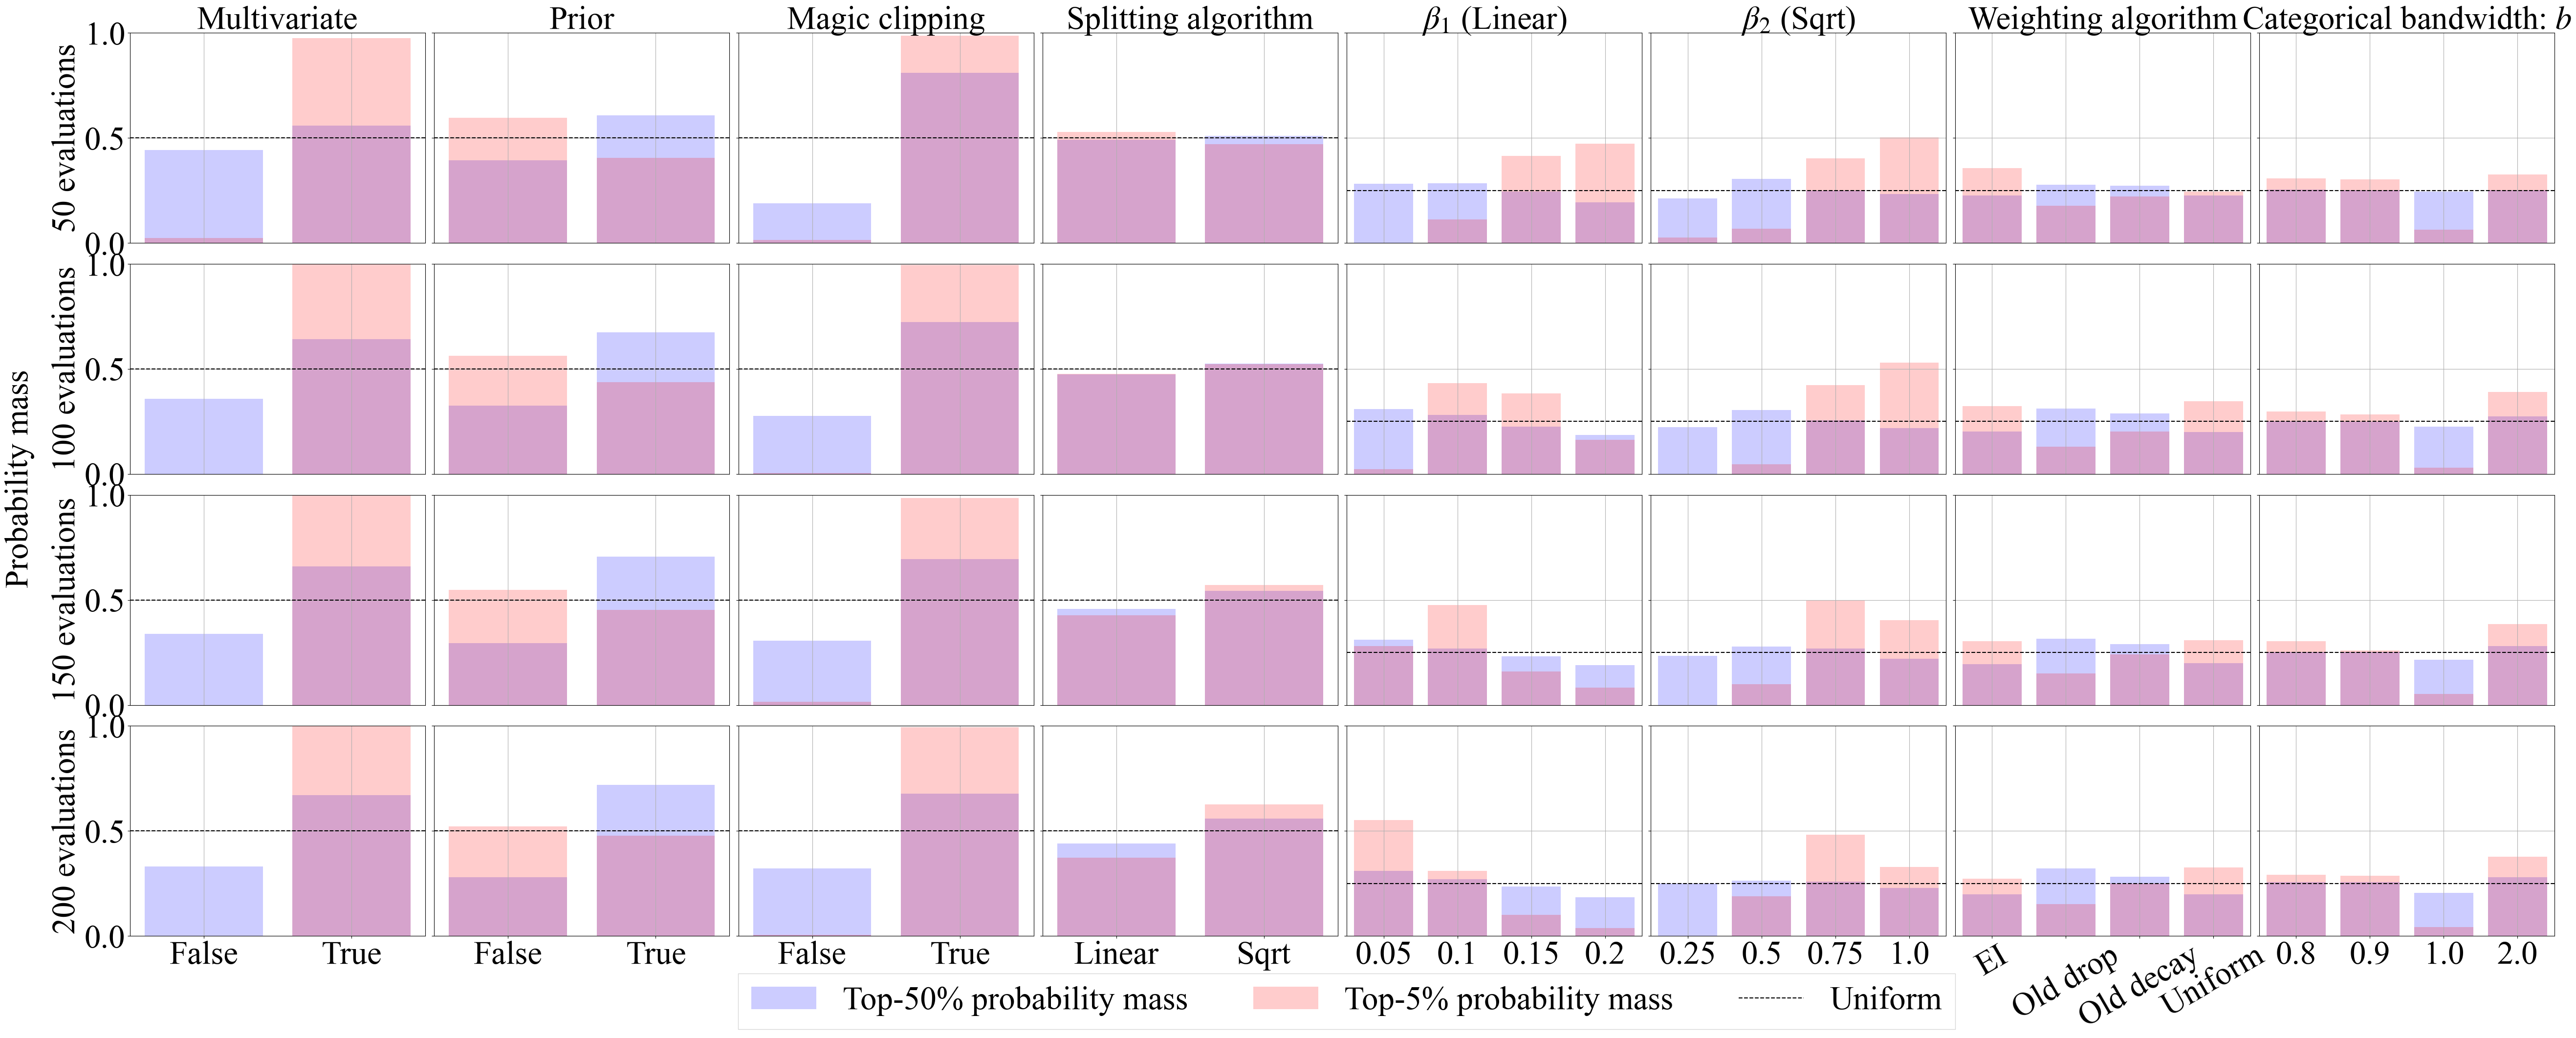

In [12]:
bench_names = ["parkinsons_telemonitoring", "protein_structure", "naval_propulsion", "slice_localization"]

param_name_dict["top"] = "Categorical bandwidth: $b$"

fig, axes = plt.subplots(
    nrows=4,
    ncols=8,
    figsize=(64, 24),
    sharey=True,
    gridspec_kw=dict(
        wspace=0.03,
        hspace=0.1,
    )
)

plot_pdf(bench_names, bbox_to_anchor=(0, -0.1))
plt.savefig(f"figs/hpolib-anova.pdf", bbox_inches="tight")

\begin{tabular}{lllll}
 & 0 & 1 & 2 & 3 \\
Multivariate & 11.47\% & 16.16\% & 17.05\% & 19.79\% \\
Prior & 33.05\% & 38.34\% & 40.41\% & 41.88\% \\
Magic clipping & 19.53\% & 13.59\% & 12.29\% & 11.90\% \\
Splitting algorithm & 1.16\% & 0.94\% & 1.45\% & 1.52\% \\
$\beta_1$ (Linear) & 3.24\% & 1.34\% & 2.68\% & 2.94\% \\
$\beta_2$ (Sqrt) & 12.84\% & 10.78\% & 8.81\% & 5.29\% \\
Weighting algorithm & 5.80\% & 10.22\% & 9.89\% & 10.38\% \\
Categorical bandwidth: $b$ & 12.91\% & 8.62\% & 7.41\% & 6.30\% \\
\end{tabular}

\begin{tabular}{lllll}
 & 0 & 1 & 2 & 3 \\
Multivariate & 20.27\% & 23.69\% & 20.26\% & 16.73\% \\
Prior & 5.63\% & 8.17\% & 8.09\% & 7.62\% \\
Magic clipping & 3.75\% & 5.26\% & 9.45\% & 11.42\% \\
Splitting algorithm & 1.22\% & 3.98\% & 6.03\% & 5.28\% \\
$\beta_1$ (Linear) & 34.47\% & 12.62\% & 10.23\% & 11.18\% \\
$\beta_2$ (Sqrt) & 20.15\% & 28.97\% & 25.91\% & 28.18\% \\
Weighting algorithm & 5.28\% & 11.52\% & 12.87\% & 12.66\% \\
Categorical bandwidth: $b$ & 9.22\

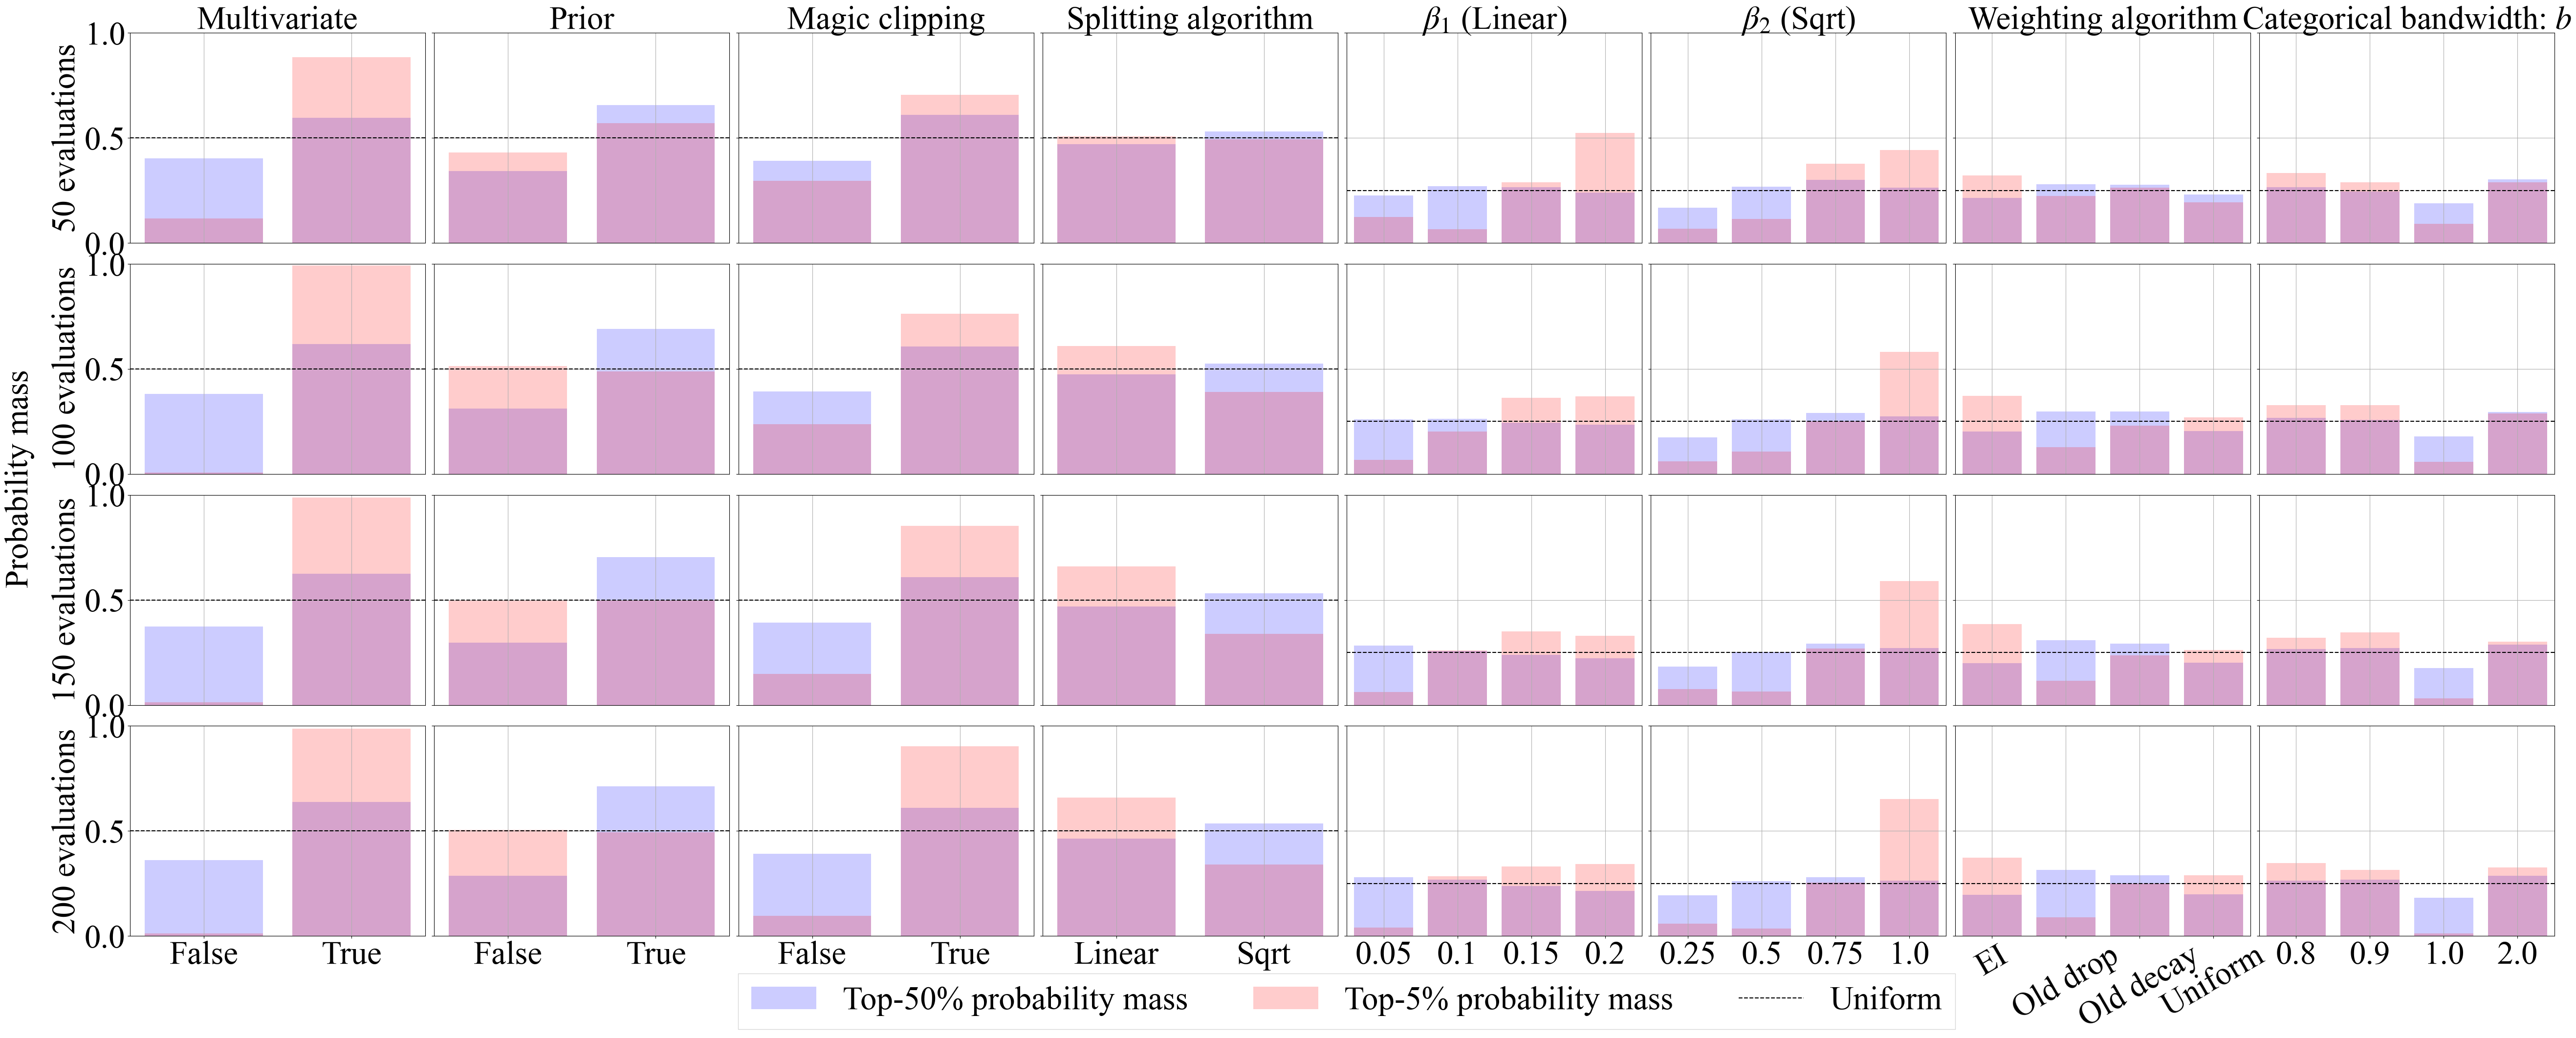

In [13]:
bench_names = ["cifar10", "fashion_mnist", "colorectal_histology"]

fig, axes = plt.subplots(
    nrows=4,
    ncols=8,
    figsize=(64, 24),
    sharey=True,
    gridspec_kw=dict(
        wspace=0.03,
        hspace=0.1,
    )
)

plot_pdf(bench_names, bbox_to_anchor=(0, -0.1))
plt.savefig(f"figs/jahs-anova.pdf", bbox_inches="tight")

In [ ]:
"""
Columns:
    - target_name
    - n_evals
    - top-quantile
    - HPI param 1
        - param 1: choice 1 rank
        - param 1: choice 2 rank
        ...
    - HPI param 2
    ...
    - HPI param N
"""

from typing import Any, Dict


def _subproc(param_name: str, hpi: float, order: Dict[Any, float]) -> Dict[str, Any]:
    out = {}
    out[f"{param_name}_hpi"] = hpi
    for choice, rank in order.items():
        out[f"{param_name}_{choice}_rank"] = rank

    return out


def analyze(target_name, target_config_table):
    target_mean = mean_vals[target_cols == target_name]
    target_epochs = np.asarray([50, 100, 150, 200]) - 1

    F_dict = {e: [] for e in target_epochs}
    for idx in target_config_table.index:
        m = target_mean[target_mean.setting_index == idx].iloc[0].to_numpy()[2:].astype(np.float32)
        for e in target_epochs:
            F_dict[e].append(m[e])
    else:
        F_dict = {e: np.asarray(F) for e, F in F_dict.items()}

    results = []
    for e, F in F_dict.items():
        entry = {"top_quantile": 0.1, "target_name": target_name, "n_evals": e + 1}
        hpi_dict, order = compute_hpi(target_config_table, F, gamma_local=0.1)
        for param_name in hpi_dict.keys():
            entry.update(_subproc(param_name, hpi=hpi_dict[param_name], order=order[param_name]))
        else:
            results.append(entry)

        entry = {"top_quantile": 0.01, "target_name": target_name, "n_evals": e + 1}
        hpi_dict, order = compute_hpi(target_config_table, F, gamma_local=0.01, gamma_global=0.1)
        for param_name in hpi_dict.keys():
            entry.update(_subproc(param_name, hpi=hpi_dict[param_name], order=order[param_name]))
        else:
            results.append(entry)
    
    return pd.DataFrame(results)

In [ ]:
bench_names = list(set([name[:-4] for name in target_names if "30d" in name]))
BENCH_LABEL_DICT = {
    "Ackley": "Ackley",
    "Griewank": "Griewank",
    "KTablet": "K-Tablet",
    "Levy": "Levy",
    "Perm": "Perm",
    "Rastrigin": "Rastrigin",
    "Rosenbrock": "Rosenbrock",
    "Schwefel": "Schwefel",
    "Sphere": "Sphere",
    "Styblinski": "Styblinski",
    "WeightedSphere": "Weighted sphere",
    "XinSheYang": "Xin-She-Yang",
}

config_num_without_alpha = config_num.drop(columns=["alpha"])
config_num_linear = config_num.drop(columns=[col for col in config_num.columns if col != "alpha"])
config_num_sqrt = config_num.drop(columns=[col for col in config_num.columns if col != "alpha"])

results = []
results_linear, results_sqrt = [], []
for bench_name in bench_names:
    results.append(analyze(f"{bench_name}_05d", config_num_without_alpha))
    results.append(analyze(f"{bench_name}_10d", config_num_without_alpha))
    results.append(analyze(f"{bench_name}_30d", config_num_without_alpha))

pd.concat(results)